# **AABW Assignment 3: Housing Problem (Report)**

**Date:** 14 October 2024

**Authors:**  
* Jorge Matamala Yepes (13955764)  
* Hubert Radosław Perliński (13985612)  


# 1. Importing Model Parameters
In this first stage, we load the Excel sheet containing the predefined model parameters that will be used in the model to achieve the optimal apartment allocation that maximises total profits given the set of constraints provided.


In [ ]:
import sys
at_colab = 'google.colab' in sys.modules
if at_colab:
    %pip install xlsxwriter
    %pip install pyomo
    %pip install gurobipy
    !apt-get install -y -qq coinor-cbc
import gurobipy
import pandas as pd
import pyomo.environ as pyo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 88.5 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unsele

In [ ]:
file_path = 'Housing Problem - parameter values.xlsx'

# Load the Excel file
excel_file = pd.ExcelFile(file_path)

# Get the sheet names
sheet_names = excel_file.sheet_names

# Load each sheet into a pandas DataFrame
dfs = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheet_names}

# Now, dfs is a dictionary where the key is the sheet name and the value is the corresponding DataFrame
df_number_of_apartments = dfs['number_of_apartments']
df_profit_height_69 = dfs['profit_height_69']
df_profit_height_120 = dfs['profit_height_120']
df_profit_height_168 = dfs['profit_height_168']

sector_constraints = {
    'social': 0.4,
    'middle': 0.4,
    'free': 0.0
}

owner_constraints = {
    'investor': 0.7,      # Investors must own at least 70% of the apartments
    'corporation': 0.0,   # No minimum for corporations
    'private': 0.0        # No minimum for private owners
}

#delta = {'investor': 0.7}

gamma = {
    'social': 40,
    'middle': 50,
    'free': 0
}

alpha_ih = {
    ('social', 'corporation'): 40,
    ('middle', 'corporation'): 50,
    ('free', 'investor'): 60,
    ('social', 'investor'): 0,
    ('middle', 'investor'): 0,
    ('free', 'corporation'): 0,
    ('social', 'private'): 0,
    ('middle', 'private'): 0,
    ('free', 'private'): 0
}

In [ ]:
df_number_of_apartments

,area,configuration,no_of_apartments
0,36,aa,4
1,36,ab,2
2,36,ac,2
3,36,bb,0
4,36,bc,0
...,...,...,...
105,131,cd,0
106,131,ce,2
107,131,dd,0
108,131,de,2


# 2. Linear Optimsation Model


In [ ]:
def apartment_optimization(number_of_apartments_df, profit_df, K, sector_constraints, owner_constraints, gamma_i, alpha_ih):
    # Create the model
    m = pyo.ConcreteModel('ApartmentOptimization')

    # Define Sets
    m.sectors = pyo.Set(initialize=profit_df['sector'].unique())  # Sectors (i)
    m.areas = pyo.Set(initialize=number_of_apartments_df['area'].unique())  # Areas (j)
    m.owners = pyo.Set(initialize=profit_df['owner'].unique())  # Owners (h)
    m.configurations = pyo.Set(initialize=number_of_apartments_df['configuration'].unique())  # Configurations (v)

    # Define Parameters from Excel data
    m.R_jv = pyo.Param(m.areas, m.configurations, initialize=number_of_apartments_df.set_index(['area', 'configuration']).to_dict()['no_of_apartments'])  # Number of apartments with area j and configuration v
    m.O_ijh = pyo.Param(m.sectors, m.areas, m.owners, initialize=profit_df.set_index(['sector', 'area', 'owner']).to_dict()['profit'], default=0)  # Profit per apartment

    # Define Decision Variables
    m.Xv = pyo.Var(m.configurations, bounds=(0, K), within=pyo.NonNegativeIntegers)  # Number of floors with configuration v
    m.Yijh = pyo.Var(m.sectors, m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of apartments
    m.Wvh = pyo.Var(m.configurations, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of floors by owner h
    m.Zjh = pyo.Var(m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Total apartments by area and owner

    # Objective function: Maximize total profit
    @m.Objective(sense=pyo.maximize)
    def obj(m):
        return pyo.quicksum(m.O_ijh[i, j, h] * m.Yijh[i, j, h] for i in m.sectors for j in m.areas for h in m.owners)

    # Constraints

    # 1. Total number of floors equals K
    @m.Constraint()
    def total_floors(m):
        return pyo.quicksum(m.Xv[v] for v in m.configurations) == K

    # 2. Total number of apartments consistency
    @m.Constraint(m.areas)
    def total_apartments(m, j):
        return pyo.quicksum(m.R_jv[j, v] * m.Xv[v] for v in m.configurations) == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for h in m.owners)

    # 3. Owner floor configuration
    @m.Constraint(m.configurations)
    def owner_floors(m, v):
        return pyo.quicksum(m.Wvh[v, h] for h in m.owners) == m.Xv[v]

    # 4. No multiple owners on the same floor
    @m.Constraint(m.areas, m.owners)
    def no_multiple_owners(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Wvh[v, h] * m.R_jv[j, v] for v in m.configurations)

    # 5. Ensure consistency of apartments assigned by owner and area
    @m.Constraint(m.areas, m.owners)
    def apartments_owner_area(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors)

    # 6. Sector constraints (minimum percentage in total program)
    @m.Constraint(m.sectors)
    def sector_minimum(m, i):
        return pyo.quicksum(m.Yijh[i, j, h] for j in m.areas for h in m.owners) >= sector_constraints[i] * pyo.quicksum(m.Yijh[l, j, h] for l in m.sectors for j in m.areas for h in m.owners)

    # 7. Minimal average floor area of apartments in a sector
    @m.Constraint(m.sectors)
    def minumum_average_floor_area(m, i):
        return pyo.quicksum(j * m.Yijh[i,j,h] for j in m.areas for h in m.owners) >= gamma_i[i] * pyo.quicksum(m.Yijh[i,j,h] for j in m.areas for h in m.owners)

    # 8. Minimal floor area for sector and owner
    @m.Constraint(m.sectors, m.areas, m.owners)
    def minimum_floor_area_constraint(m, i, j, h):
      if j < alpha_ih[i, h]:
          return m.Yijh[i, j, h] == 0
      else:
          return pyo.Constraint.Skip

    # 9. No free sector apartments for housing corporation
    @m.Constraint(m.areas)
    def no_free_sector_apartments(m, j):
        return m.Yijh['free', j, 'corporation'] == 0

    # 10. Owner constraints (e.g., percentage for investors)
    @m.Constraint(m.owners)
    def owner_percentage(m, h):
        return pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for j in m.areas) >= owner_constraints[h] * pyo.quicksum(m.Yijh[i, j, p] for i in m.sectors for j in m.areas for p in m.owners)

    return m

In [ ]:
def solve_model(model, solv='gurobi', reporting = False):

    # if solv == 'gurobi':
    #   !pip install gurobipy
    #import gurobipy

    # Create solver object
    solver = pyo.SolverFactory(solv)

    #print("Trying to solve the model")
    # Solve the model
    results = solver.solve(model)
    #print("Solved")
    # Check if the solver found an optimal solution
    if results.solver.status == pyo.SolverStatus.ok and results.solver.termination_condition == pyo.TerminationCondition.optimal:
        # Print additional model outcomes
        print_optimization_results(model, reporting)
        #return model

    else:
        print("Solver did not find an optimal solution.")
        return None


# Helper function to print optimization results
def print_optimization_results(mod,more_reporting):
    # Print the maximum profit
    max_profit = pyo.value(mod.obj)
    print(f"Maximum Profit: {max_profit}\n")

    if more_reporting == True:

      # Print floors per configuration
      print("Floors per configuration:")
      for v in m.configurations:
          print(f" - {v}: {pyo.value(mod.Xv[v])} floors")

      # Print apartments allocated by sector, area, and owner
      print("\nApartments per sector, area, and owner:")
      for i in mod.sectors:
          for j in mod.areas:
              for h in mod.owners:
                  value = pyo.value(m.Yijh[i, j, h])
                  if value > 0:
                      print(f" - Sector {i}, Area {j}, Owner {h}: {value} apartments")

      # Print floors allocated to owners by configuration
      print("\nFloors allocated to owners by configuration:")
      for v in mod.configurations:
          for h in mod.owners:
              value = pyo.value(mod.Wvh[v, h])
              if value > 0:
                  print(f" - Configuration {v}, Owner {h}: {value} floors")

      # Print total apartments by area and owner
      print("\nTotal apartments by area and owner:")
      for j in mod.areas:
          for h in mod.owners:
              value = pyo.value(mod.Zjh[j, h])
              if value > 0:
                  print(f" - Area {j}, Owner {h}: {value} apartments")

# Solve the model
K = 56
m = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma, alpha_ih)
solve_model(m, solv='cbc', reporting=True)


Maximum Profit: 39187428.96979929

Floors per configuration:
 - aa: 24.0 floors
 - ab: 0.0 floors
 - ac: 7.0 floors
 - bb: 0.0 floors
 - bc: 0.0 floors
 - cc: 1.0 floors
 - cd: 0.0 floors
 - ce: 1.0 floors
 - dd: 0.0 floors
 - de: 0.0 floors
 - ee: 23.0 floors

Apartments per sector, area, and owner:
 - Sector social, Area 36, Owner investor: 110.0 apartments
 - Sector social, Area 42, Owner investor: 63.0 apartments
 - Sector social, Area 48, Owner investor: 1.0 apartments
 - Sector social, Area 60, Owner corporation: 6.0 apartments
 - Sector social, Area 71, Owner corporation: 6.0 apartments
 - Sector middle, Area 42, Owner investor: 47.0 apartments
 - Sector middle, Area 48, Owner investor: 109.0 apartments
 - Sector middle, Area 60, Owner investor: 14.0 apartments
 - Sector middle, Area 71, Owner investor: 14.0 apartments
 - Sector middle, Area 131, Owner corporation: 2.0 apartments
 - Sector free, Area 131, Owner private: 92.0 apartments

Floors allocated to owners by configuratio

# 3. Comparing profit for different number of floors.

In [ ]:
print('For 23 floors:')
K = 23
m = apartment_optimization(df_number_of_apartments, df_profit_height_69, K, sector_constraints, owner_constraints, gamma, alpha_ih)
solve_model(m, solv='cbc')
print("Profit per floor:", m.obj()/K)


print('\n\nFor 40 floors:')
K = 40
m = apartment_optimization(df_number_of_apartments, df_profit_height_120, K, sector_constraints, owner_constraints, gamma, alpha_ih)
solve_model(m, solv='cbc')
print("Profit per floor:", m.obj()/K)

print('\n\n For 56 floors:')
K = 56
m = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma, alpha_ih)
solve_model(m, solv='cbc')
print("Profit per floor:", m.obj()/K)

For 23 floors:
Maximum Profit: 17483910.863021515

Profit per floor: 760170.0375226745


For 40 floors:
Maximum Profit: 29622229.854210615

Profit per floor: 740555.7463552654


 For 56 floors:
Maximum Profit: 39187428.96979929

Profit per floor: 699775.5173178444


We see that the largest profit we can get is for 56 floors. The profit per floor also does not change drasticlly. Hence, the further analysis will be conducted on 56 floors.

# 3. Post Processing


In [ ]:
def post_process_model(m, df_number_of_apartments):
    import pandas as pd
    import numpy as np

    # Initialize an empty list to store floor data
    floor_data = []

    # Initialize floor number counter
    floor_number = 1

    # Create a mapping from configurations to apartment areas and counts
    # Each configuration maps to a dictionary {area: no_of_apartments}
    config_apartments = df_number_of_apartments.groupby('configuration').apply(
        lambda x: x.set_index('area')['no_of_apartments'].to_dict()
    ).to_dict()

    # Step 1: Build the floor list with owners and configurations
    print("Assigning configurations and owners to floors...\n")
    for v in m.configurations:
        for h in m.owners:
            num_floors = int(pyo.value(m.Wvh[v, h]))
            if num_floors > 0:
                for _ in range(num_floors):
                    # Append floor information
                    floor_data.append({
                        'Floor Number': floor_number,
                        'Owner': h,
                        'Configuration': v
                    })
                    floor_number += 1

    # Convert floor data to DataFrame
    floors_df = pd.DataFrame(floor_data)

    # Step 2: Add apartment sizes and counts based on configuration
    print("Adding apartment sizes and counts to each floor...\n")
    # Transform the apartment details into a list of (area, no_of_apartments) tuples
    floors_df['Apartment Details'] = floors_df['Configuration'].apply(
        lambda v: list(config_apartments[v].items())
    )

    # Expand the apartment details into separate rows
    floors_expanded = floors_df.explode('Apartment Details').reset_index(drop=True)

    # Split 'Apartment Details' into 'Area' and 'Total Apartments'
    floors_expanded[['Area', 'Total Apartments']] = pd.DataFrame(
        floors_expanded['Apartment Details'].tolist(), index=floors_expanded.index
    )

    # Drop the 'Apartment Details' column as it's no longer needed
    floors_expanded = floors_expanded.drop(columns=['Apartment Details'])

    # Convert 'Area' and 'Total Apartments' to numeric types
    floors_expanded['Area'] = floors_expanded['Area'].astype(float)
    floors_expanded['Total Apartments'] = floors_expanded['Total Apartments'].astype(int)

    # Step 3: Initialize sector allocations per floor
    sectors = list(m.sectors)
    for sector in sectors:
        floors_expanded[sector] = 0  # Initialize sector columns

    # Step 4: Allocate apartments to sectors based on model outputs
    print("Allocating apartments to sectors per floor...\n")

    # Collect total apartments per (sector, area, owner) from the model
    total_apartments = {}
    for i in m.sectors:
        for j in m.areas:
            for h in m.owners:
                qty = int(pyo.value(m.Yijh[i, j, h]))
                if qty > 0:
                    total_apartments[(i, float(j), h)] = qty  # Convert area to float

    # Allocate apartments to floors
    allocation_tracker = {}  # Keep track of allocations per (sector, area, owner)

    # Iterate over each floor
    for idx, row in floors_expanded.iterrows():
        owner = row['Owner']
        area = row['Area']
        total_apts = row['Total Apartments']

        # Collect the sectors that have apartments of this area and owner
        possible_sectors = [i for i in sectors if (i, area, owner) in total_apartments]

        # If no sectors need this apartment, skip allocation
        if not possible_sectors:
            continue

        # Allocate apartments to sectors
        for sector in possible_sectors:
            key = (sector, area, owner)
            # Calculate remaining apartments to allocate for this key
            allocated = allocation_tracker.get(key, 0)
            remaining = total_apartments[key] - allocated

            # Calculate the number of apartments to allocate on this floor
            # Allocate as many as possible up to the total apartments on this floor
            allocation = min(remaining, total_apts - sum([row[s] for s in sectors]))

            if allocation > 0:
                # Update the allocation in the DataFrame
                floors_expanded.at[idx, sector] += allocation
                # Update the allocation tracker
                allocation_tracker[key] = allocated + allocation

                # Break if all apartments on the floor are allocated
                if sum([floors_expanded.at[idx, s] for s in sectors]) >= total_apts:
                    break

    # Verification step: Check if total allocations match the model outputs
    print("Verifying allocations...\n")
    for key, total in total_apartments.items():
        sector, area, owner = key
        allocated_total = floors_expanded[
            (floors_expanded['Area'] == area) &
            (floors_expanded['Owner'] == owner)
        ][sector].sum()
        assert allocated_total == total, f"Mismatch in allocations for {key}: Model={total}, Allocated={allocated_total}"
        print(f"Verified allocation for {key}: {allocated_total} apartments")

    # Rearrange columns for clarity
    columns_order = ['Floor Number', 'Owner', 'Configuration', 'Area', 'Total Apartments'] + sectors
    floors_expanded = floors_expanded[columns_order]


    # FLOORS ORDER SORTING
     # Reorder Floors Based on Minimum Apartment Area
    print("\nReordering floors based on minimum apartment size...\n")

    # Step 5: Compute the minimum apartment area per floor
    min_area_per_floor = floors_expanded.groupby('Floor Number')['Area'].min().reset_index()
    min_area_per_floor.columns = ['Floor Number', 'Min Area']

    # Step 6: Sort the floors based on the minimum apartment area
    sorted_floors = min_area_per_floor.sort_values(by=['Min Area', 'Floor Number']).reset_index(drop=True)
    sorted_floors['New Floor Number'] = sorted_floors.index + 1  # Reassign floor numbers starting from 1

    # Create a mapping from old floor numbers to new floor numbers
    floor_number_mapping = dict(zip(sorted_floors['Floor Number'], sorted_floors['New Floor Number']))

    # Step 7: Apply the new floor numbers to the floors_expanded DataFrame
    floors_expanded['Floor Number'] = floors_expanded['Floor Number'].map(floor_number_mapping)

    # Step 8: Sort the DataFrame based on the new floor numbers and reset index
    floors_expanded = floors_expanded.sort_values(by=['Floor Number', 'Area']).reset_index(drop=True)

    # Final DataFrame
    print("Final tower design DataFrame created with reordered floors.\n")

    return floors_expanded


In [ ]:
# Call the post-processing function
tower_design_df = post_process_model(m, df_number_of_apartments)

# Display the first few rows of the DataFrame
tower_design_df.head()


Assigning configurations and owners to floors...

Adding apartment sizes and counts to each floor...



<ipython-input-7-cc186ad1c4b6>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  config_apartments = df_number_of_apartments.groupby('configuration').apply(


Allocating apartments to sectors per floor...

Verifying allocations...

Verified allocation for ('social', 36.0, 'investor'): 110 apartments
Verified allocation for ('social', 42.0, 'investor'): 63 apartments
Verified allocation for ('social', 48.0, 'investor'): 1 apartments
Verified allocation for ('social', 60.0, 'corporation'): 6 apartments
Verified allocation for ('social', 71.0, 'corporation'): 6 apartments
Verified allocation for ('middle', 42.0, 'investor'): 47 apartments
Verified allocation for ('middle', 48.0, 'investor'): 109 apartments
Verified allocation for ('middle', 60.0, 'investor'): 14 apartments
Verified allocation for ('middle', 71.0, 'investor'): 14 apartments
Verified allocation for ('middle', 131.0, 'corporation'): 2 apartments
Verified allocation for ('free', 131.0, 'private'): 92 apartments

Reordering floors based on minimum apartment size...

Final tower design DataFrame created with reordered floors.



,Floor Number,Owner,Configuration,Area,Total Apartments,social,middle,free
0,1,investor,aa,36.0,4,4,0,0
1,1,investor,aa,42.0,4,4,0,0
2,1,investor,aa,48.0,4,1,4,0
3,1,investor,aa,52.0,0,0,0,0
4,1,investor,aa,60.0,0,0,0,0


In [ ]:
tower_design_df[tower_design_df['Floor Number']==1]

,Floor Number,Owner,Configuration,Area,Total Apartments,social,middle,free
0,1,investor,aa,36.0,4,4,0,0
1,1,investor,aa,42.0,4,4,0,0
2,1,investor,aa,48.0,4,1,4,0
3,1,investor,aa,52.0,0,0,0,0
4,1,investor,aa,60.0,0,0,0,0
5,1,investor,aa,68.0,0,0,0,0
6,1,investor,aa,70.0,0,0,0,0
7,1,investor,aa,71.0,0,0,0,0
8,1,investor,aa,96.0,0,0,0,0
9,1,investor,aa,131.0,0,0,0,0


In [ ]:
def create_apartment_summary_table(floors_expanded):
    import pandas as pd

    # Initialize a list to hold the summary for each floor
    floor_summaries = []

    # Group the DataFrame by 'Floor Number'
    grouped = floors_expanded.groupby('Floor Number')

    # Iterate over each floor
    for floor_number, group in grouped:
        # Get the unique Owner and Design (Configuration) for the floor
        owner = group['Owner'].iloc[0]
        design = group['Configuration'].iloc[0]

        # Initialize a list to hold apartment summaries for this floor
        apartments_summary = []

        # Iterate over each unique apartment area on this floor
        for area in group['Area'].unique():
            # Select the rows corresponding to this area
            area_group = group[group['Area'] == area]

            # Initialize a dictionary to hold sector counts
            sector_counts = {}

            # For each sector, get the number of apartments if greater than zero
            for sector in ['social', 'middle', 'free']:
                count = area_group[sector].sum()
                if count > 0:
                    sector_counts[sector] = int(count)

            # If there are apartments in any sector for this area
            if sector_counts:
                # Create a string summarizing the sectors and counts
                sector_summary = ', '.join([f"{sector}:{count}" for sector, count in sector_counts.items()])
                # Create the area summary string
                area_summary = f"{int(area)}m²: [{sector_summary}]"
                # Add to the list of apartment summaries
                apartments_summary.append(area_summary)

        # Combine the apartment summaries into a single string
        apartments_summary_string = ', '.join(apartments_summary)

        # Append the floor summary to the list
        floor_summaries.append({
            'Floor': int(floor_number),
            'Design': design,
            'Owner': owner,
            'Apartments (size, sector)': apartments_summary_string
        })

    # Create a DataFrame from the floor summaries
    summary_df = pd.DataFrame(floor_summaries)

    # Sort the DataFrame by 'Floor' for clarity
    summary_df = summary_df.sort_values('Floor').reset_index(drop=True)

    # Return the final summary DataFrame
    return summary_df


In [ ]:
apartment_summary_df = create_apartment_summary_table(tower_design_df)

# Display the first few rows of the summary DataFrame
apartment_summary_df.head()

,Floor,Design,Owner,"Apartments (size, sector)"
0,1,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [soc..."
1,2,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [mid..."
2,3,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [mid..."
3,4,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [mid..."
4,5,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [mid..."


In [ ]:
# Import pandas (if not already imported)
import pandas as pd

# Set pandas display options to show all columns and all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Do not truncate column content

# Assuming 'apartment_summary_df' is the DataFrame generated by the previous function
# Display the entire DataFrame
apartment_summary_df


,Floor,Design,Owner,"Apartments (size, sector)"
0,1,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [social:1, middle:4]"
1,2,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
2,3,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
3,4,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
4,5,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
5,6,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
6,7,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
7,8,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
8,9,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"
9,10,aa,investor,"36m²: [social:4], 42m²: [social:4], 48m²: [middle:4]"


# 4. Checking for alternative solutions that are still optimal.
We are introducing new constraints. One ensures that the profit is the same as the optimal. Another makes the current optimal solution infeasable by altering the value of one variable.

In [ ]:
def apartment_optimization_alt(number_of_apartments_df, profit_df, K, sector_constraints, owner_constraints, gamma, alpha_ih):
    # Create the model
    m = pyo.ConcreteModel('ApartmentOptimization')

    # Define Sets
    m.sectors = pyo.Set(initialize=profit_df['sector'].unique())  # Sectors (i)
    m.areas = pyo.Set(initialize=number_of_apartments_df['area'].unique())  # Areas (j)
    m.owners = pyo.Set(initialize=profit_df['owner'].unique())  # Owners (h)
    m.configurations = pyo.Set(initialize=number_of_apartments_df['configuration'].unique())  # Configurations (v)

    # Define Parameters from Excel data
    m.R_jv = pyo.Param(m.areas, m.configurations, initialize=number_of_apartments_df.set_index(['area', 'configuration']).to_dict()['no_of_apartments'])  # Number of apartments with area j and configuration v
    m.O_ijh = pyo.Param(m.sectors, m.areas, m.owners, initialize=profit_df.set_index(['sector', 'area', 'owner']).to_dict()['profit'], default=0)  # Profit per apartment

    # Define Decision Variables
    m.Xv = pyo.Var(m.configurations, bounds=(0, K), within=pyo.NonNegativeIntegers)  # Number of floors with configuration v
    m.Yijh = pyo.Var(m.sectors, m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of apartments
    m.Wvh = pyo.Var(m.configurations, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of floors by owner h
    m.Zjh = pyo.Var(m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Total apartments by area and owner

    # Objective function: Maximize total profit
    @m.Objective(sense=pyo.maximize)
    def obj(m):
        return pyo.quicksum(m.O_ijh[i, j, h] * m.Yijh[i, j, h] for i in m.sectors for j in m.areas for h in m.owners)

    # Constraints

    # 1. Total number of floors equals K
    @m.Constraint()
    def total_floors(m):
        return pyo.quicksum(m.Xv[v] for v in m.configurations) == K

    # 2. Total number of apartments consistency
    @m.Constraint(m.areas)
    def total_apartments(m, j):
        return pyo.quicksum(m.R_jv[j, v] * m.Xv[v] for v in m.configurations) == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for h in m.owners)

    # 3. Owner floor configuration
    @m.Constraint(m.configurations)
    def owner_floors(m, v):
        return pyo.quicksum(m.Wvh[v, h] for h in m.owners) == m.Xv[v]

    # 4. No multiple owners on the same floor
    @m.Constraint(m.areas, m.owners)
    def no_multiple_owners(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Wvh[v, h] * m.R_jv[j, v] for v in m.configurations)

    # 5. Ensure consistency of apartments assigned by owner and area
    @m.Constraint(m.areas, m.owners)
    def apartments_owner_area(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors)

    # 6. Sector constraints (minimum percentage in total program)
    @m.Constraint(m.sectors)
    def sector_minimum(m, i):
        return pyo.quicksum(m.Yijh[i, j, h] for j in m.areas for h in m.owners) >= sector_constraints[i] * pyo.quicksum(m.Yijh[l, j, h] for l in m.sectors for j in m.areas for h in m.owners)

    # 7. Minimal average floor area of apartments in a sector
    @m.Constraint(m.sectors)
    def minumum_average_floor_area(m, i):
        return pyo.quicksum(j * m.Yijh[i,j,h] for j in m.areas for h in m.owners) >= gamma[i] * pyo.quicksum(m.Yijh[i,j,h] for j in m.areas for h in m.owners)

    # 8. Minimal floor area for sector and owner
    @m.Constraint(m.sectors, m.areas, m.owners)
    def minimum_floor_area_constraint(m, i, j, h):
      if j < alpha_ih[i, h]:
          return m.Yijh[i, j, h] == 0
      else:
          return pyo.Constraint.Skip

    # 9. No free sector apartments for housing corporation
    @m.Constraint(m.areas)
    def no_free_sector_apartments(m, j):
        return m.Yijh['free', j, 'corporation'] == 0

    # 10. Owner constraints (e.g., percentage for investors)
    @m.Constraint(m.owners)
    def owner_percentage(m, h):
        return pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for j in m.areas) >= owner_constraints[h] * pyo.quicksum(m.Yijh[i, j, p] for i in m.sectors for j in m.areas for p in m.owners)

    #Find another optimal solution with a different apartment distribution.
    @m.Constraint()
    def best(m):
        return pyo.quicksum(m.O_ijh[i, j, h] * m.Yijh[i, j, h] for i in m.sectors for j in m.areas for h in m.owners) >= 39187428.96979929
    @m.Constraint()
    def different_o(m):
        return m.Xv['aa']>=25


    return m

In [ ]:
# Solve the model
K = 56
m2 = apartment_optimization_alt(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma, alpha_ih)
solve_model(m2, solv='cbc',reporting=True)

Maximum Profit: 39187428.96979929

Floors per configuration:
 - aa: 25.0 floors
 - ab: 0.0 floors
 - ac: 5.0 floors
 - bb: 0.0 floors
 - bc: 0.0 floors
 - cc: 2.0 floors
 - cd: 0.0 floors
 - ce: 1.0 floors
 - dd: 0.0 floors
 - de: 0.0 floors
 - ee: 23.0 floors

Apartments per sector, area, and owner:
 - Sector social, Area 36, Owner investor: 110.0 apartments
 - Sector social, Area 42, Owner investor: 63.0 apartments
 - Sector social, Area 48, Owner investor: 1.0 apartments
 - Sector social, Area 60, Owner corporation: 6.0 apartments
 - Sector social, Area 71, Owner corporation: 6.0 apartments
 - Sector middle, Area 42, Owner investor: 47.0 apartments
 - Sector middle, Area 48, Owner investor: 109.0 apartments
 - Sector middle, Area 60, Owner investor: 14.0 apartments
 - Sector middle, Area 71, Owner investor: 14.0 apartments
 - Sector middle, Area 131, Owner corporation: 2.0 apartments
 - Sector free, Area 131, Owner private: 92.0 apartments

Floors allocated to owners by configuratio

In [ ]:
def apartment_optimization_alt(number_of_apartments_df, profit_df, K, sector_constraints, owner_constraints, gamma, alpha_ih):
    # Create the model
    m = pyo.ConcreteModel('ApartmentOptimization')

    # Define Sets
    m.sectors = pyo.Set(initialize=profit_df['sector'].unique())  # Sectors (i)
    m.areas = pyo.Set(initialize=number_of_apartments_df['area'].unique())  # Areas (j)
    m.owners = pyo.Set(initialize=profit_df['owner'].unique())  # Owners (h)
    m.configurations = pyo.Set(initialize=number_of_apartments_df['configuration'].unique())  # Configurations (v)

    # Define Parameters from Excel data
    m.R_jv = pyo.Param(m.areas, m.configurations, initialize=number_of_apartments_df.set_index(['area', 'configuration']).to_dict()['no_of_apartments'])  # Number of apartments with area j and configuration v
    m.O_ijh = pyo.Param(m.sectors, m.areas, m.owners, initialize=profit_df.set_index(['sector', 'area', 'owner']).to_dict()['profit'], default=0)  # Profit per apartment

    # Define Decision Variables
    m.Xv = pyo.Var(m.configurations, bounds=(0, K), within=pyo.NonNegativeIntegers)  # Number of floors with configuration v
    m.Yijh = pyo.Var(m.sectors, m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of apartments
    m.Wvh = pyo.Var(m.configurations, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of floors by owner h
    m.Zjh = pyo.Var(m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Total apartments by area and owner

    # Objective function: Maximize total profit
    @m.Objective(sense=pyo.maximize)
    def obj(m):
        return pyo.quicksum(m.O_ijh[i, j, h] * m.Yijh[i, j, h] for i in m.sectors for j in m.areas for h in m.owners)

    # Constraints

    # 1. Total number of floors equals K
    @m.Constraint()
    def total_floors(m):
        return pyo.quicksum(m.Xv[v] for v in m.configurations) == K

    # 2. Total number of apartments consistency
    @m.Constraint(m.areas)
    def total_apartments(m, j):
        return pyo.quicksum(m.R_jv[j, v] * m.Xv[v] for v in m.configurations) == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for h in m.owners)

    # 3. Owner floor configuration
    @m.Constraint(m.configurations)
    def owner_floors(m, v):
        return pyo.quicksum(m.Wvh[v, h] for h in m.owners) == m.Xv[v]

    # 4. No multiple owners on the same floor
    @m.Constraint(m.areas, m.owners)
    def no_multiple_owners(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Wvh[v, h] * m.R_jv[j, v] for v in m.configurations)

    # 5. Ensure consistency of apartments assigned by owner and area
    @m.Constraint(m.areas, m.owners)
    def apartments_owner_area(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors)

    # 6. Sector constraints (minimum percentage in total program)
    @m.Constraint(m.sectors)
    def sector_minimum(m, i):
        return pyo.quicksum(m.Yijh[i, j, h] for j in m.areas for h in m.owners) >= sector_constraints[i] * pyo.quicksum(m.Yijh[l, j, h] for l in m.sectors for j in m.areas for h in m.owners)

    # 7. Minimal average floor area of apartments in a sector
    @m.Constraint(m.sectors)
    def minumum_average_floor_area(m, i):
        return pyo.quicksum(j * m.Yijh[i,j,h] for j in m.areas for h in m.owners) >= gamma[i] * pyo.quicksum(m.Yijh[i,j,h] for j in m.areas for h in m.owners)

    # 8. Minimal floor area for sector and owner
    @m.Constraint(m.sectors, m.areas, m.owners)
    def minimum_floor_area_constraint(m, i, j, h):
      if j < alpha_ih[i, h]:
          return m.Yijh[i, j, h] == 0
      else:
          return pyo.Constraint.Skip

    # 9. No free sector apartments for housing corporation
    @m.Constraint(m.areas)
    def no_free_sector_apartments(m, j):
        return m.Yijh['free', j, 'corporation'] == 0

    # 10. Owner constraints (e.g., percentage for investors)
    @m.Constraint(m.owners)
    def owner_percentage(m, h):
        return pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for j in m.areas) >= owner_constraints[h] * pyo.quicksum(m.Yijh[i, j, p] for i in m.sectors for j in m.areas for p in m.owners)

    #Find another optimal solution with a different apartment distribution.
    @m.Constraint()
    def best(m):
        return pyo.quicksum(m.O_ijh[i, j, h] * m.Yijh[i, j, h] for i in m.sectors for j in m.areas for h in m.owners) >= 39187428.96979929
    @m.Constraint()
    def different_o(m):
        return m.Xv['aa']>=27


    return m

In [ ]:
# Solve the model
K = 56
m3 = apartment_optimization_alt(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma, alpha_ih)
solve_model(m3, solv='cbc',reporting=True)

Maximum Profit: 39187428.96979929

Floors per configuration:
 - aa: 27.0 floors
 - ab: 0.0 floors
 - ac: 1.0 floors
 - bb: 0.0 floors
 - bc: 0.0 floors
 - cc: 4.0 floors
 - cd: 0.0 floors
 - ce: 1.0 floors
 - dd: 0.0 floors
 - de: 0.0 floors
 - ee: 23.0 floors

Apartments per sector, area, and owner:
 - Sector social, Area 36, Owner investor: 110.0 apartments
 - Sector social, Area 42, Owner investor: 63.0 apartments
 - Sector social, Area 48, Owner investor: 1.0 apartments
 - Sector social, Area 60, Owner corporation: 6.0 apartments
 - Sector social, Area 71, Owner corporation: 6.0 apartments
 - Sector middle, Area 42, Owner investor: 47.0 apartments
 - Sector middle, Area 48, Owner investor: 109.0 apartments
 - Sector middle, Area 60, Owner investor: 14.0 apartments
 - Sector middle, Area 71, Owner investor: 14.0 apartments
 - Sector middle, Area 131, Owner corporation: 2.0 apartments
 - Sector free, Area 131, Owner private: 92.0 apartments

Floors allocated to owners by configuratio

We have confirmed that there are multiple tower designs that result in the same profit.

# 5. Sensitivity analysis
Which constraints are binding? What would be the effect on the profit of relaxing them?

First let's look at which constraints are binding.

In [ ]:
m.display()

Model ApartmentOptimization

  Variables:
    Xv : Size=11, Index=configurations
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         aa :     0 :  24.0 :    56 : False :  True : NonNegativeIntegers
         ab :     0 :   0.0 :    56 : False :  True : NonNegativeIntegers
         ac :     0 :   7.0 :    56 : False :  True : NonNegativeIntegers
         bb :     0 :   0.0 :    56 : False :  True : NonNegativeIntegers
         bc :     0 :   0.0 :    56 : False :  True : NonNegativeIntegers
         cc :     0 :   1.0 :    56 : False :  True : NonNegativeIntegers
         cd :     0 :   0.0 :    56 : False :  True : NonNegativeIntegers
         ce :     0 :   1.0 :    56 : False :  True : NonNegativeIntegers
         dd :     0 :   0.0 :    56 : False :  True : NonNegativeIntegers
         de :     0 :   0.0 :    56 : False :  True : NonNegativeIntegers
         ee :     0 :  23.0 :    56 : False :  True : NonNegativeIntegers
    Yijh : Size=90, Index=sectors*areas*owne

It can be seen that the minimum average floor area for social is binding. (gamma).
Sector requirements for social and middle are close to binding.

Now let's alter the data given to the model and see its impact on profits.

## Gamma (Minimum average size)

Solving for Gamma['social'] = 36
Maximum Profit: 40156566.562061355

Solving for Gamma['social'] = 37
Maximum Profit: 40156566.562061355

Solving for Gamma['social'] = 38
Maximum Profit: 40156566.562061355

Solving for Gamma['social'] = 39
Maximum Profit: 39680003.93410653

Solving for Gamma['social'] = 40
Maximum Profit: 39187428.96979929

Solving for Gamma['social'] = 41
Maximum Profit: 38656852.29718152

Solving for Gamma['social'] = 45
Maximum Profit: 34879198.19229327

Solving for Gamma['social'] = 50.5
Maximum Profit: 30428196.19789849

Solving for Gamma['middle'] = 36
Maximum Profit: 44307388.927466206

Solving for Gamma['middle'] = 40
Maximum Profit: 44307388.927466206

Solving for Gamma['middle'] = 43
Maximum Profit: 44307388.927466206

Solving for Gamma['middle'] = 44
Maximum Profit: 44307388.927466206

Solving for Gamma['middle'] = 45
Maximum Profit: 43394605.69639146

Solving for Gamma['middle'] = 46
Maximum Profit: 42752025.21583524

Solving for Gamma['middle'] = 49
Maximu

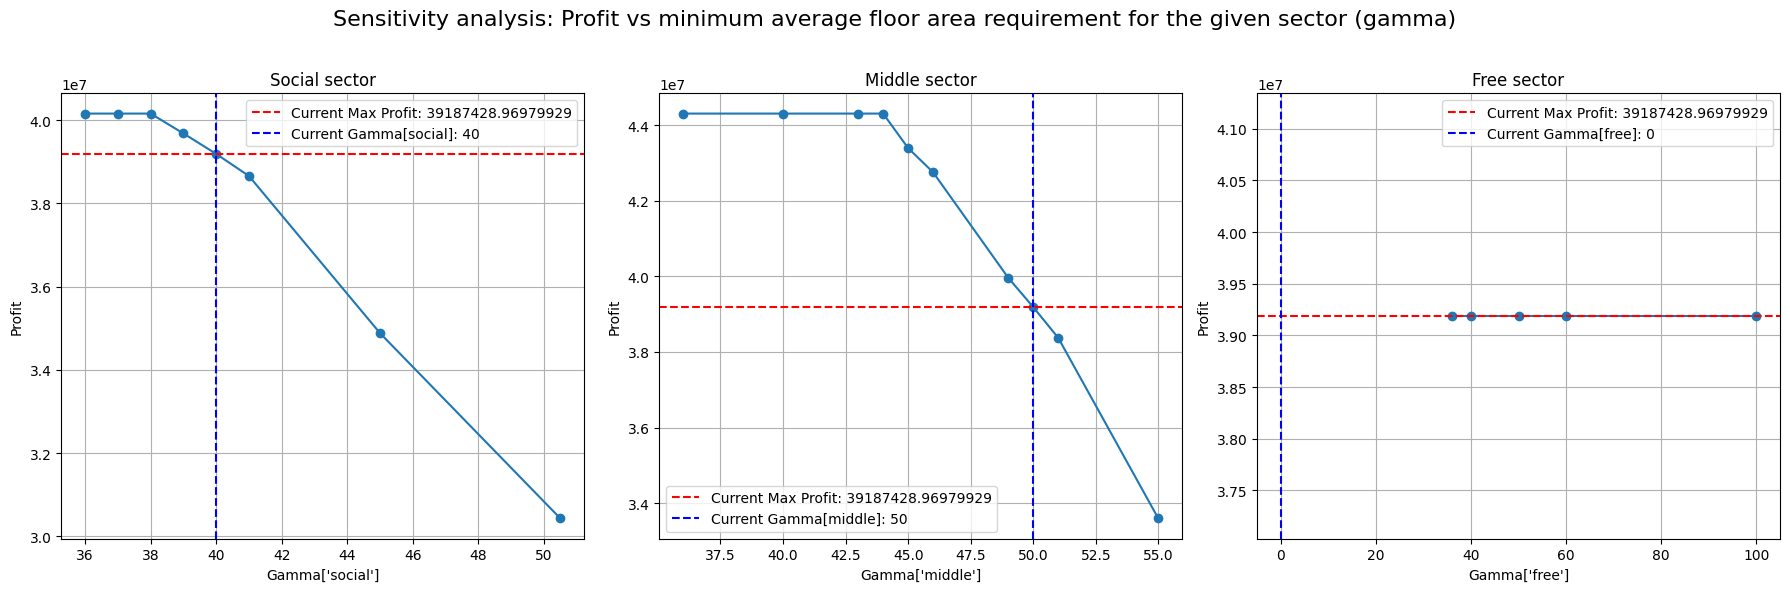

In [ ]:
import matplotlib.pyplot as plt

# Data for the first chart (gamma['social'])
gamma_s = {
    'social': 40,
    'middle': 50,
    'free': 0
}

# Parameters for the sensitivity analysis
current_gamma_social = gamma['social']  # Current gamma value for 'social'
current_profit = 39187428.96979929  # Current max profit
gamma_range_social = [36, 37, 38, 39, 40, 41, 45, 50.5]  # Range of gamma['social'] values to explore
gamma_values_social = []
profits_social = []

# ---- Calculations for the first chart (social) ----
for gamma_value in gamma_range_social:
    print(f"Solving for Gamma['social'] = {gamma_value}")

    # Update gamma['social'] to the new value
    gamma_s['social'] = gamma_value

    # Solve the model with updated gamma
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma_s, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the gamma value and the corresponding profit
    gamma_values_social.append(gamma_value)
    profits_social.append(ms.obj())

# Data for the second chart (gamma['middle'])
gamma_range_middle = [36, 40, 43, 44, 45, 46, 49, 50, 51, 55]
gamma_values_middle = []
profits_middle = []

gamma_s = {
    'social': 40,
    'middle': 50,
    'free': 0
}

# ---- Calculations for the second chart (middle) ----
for gamma_value in gamma_range_middle:
    print(f"Solving for Gamma['middle'] = {gamma_value}")

    # Update gamma['middle'] to the new value
    gamma_s['middle'] = gamma_value

    # Solve the model with updated gamma
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma_s, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the gamma value and the corresponding profit
    gamma_values_middle.append(gamma_value)
    profits_middle.append(ms.obj())

# Data for the third chart (gamma['free'])
gamma_range_free = [36, 40, 50, 60, 100]
gamma_values_free = []
profits_free = []

gamma_s = {
    'social': 40,
    'middle': 50,
    'free': 0
}

# ---- Calculations for the third chart (free) ----
for gamma_value in gamma_range_free:
    print(f"Solving for Gamma['free'] = {gamma_value}")

    # Update gamma['free'] to the new value
    gamma_s['free'] = gamma_value

    # Solve the model with updated gamma
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma_s, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the gamma value and the corresponding profit
    gamma_values_free.append(gamma_value)
    profits_free.append(ms.obj())

# ---- Plotting the three charts side by side with a common title ----
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# First plot (gamma['social'])
ax1.plot(gamma_values_social, profits_social, marker='o')
ax1.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax1.axvline(x=current_gamma_social, color='b', linestyle='--', label=f'Current Gamma[social]: {current_gamma_social}')
ax1.set_xlabel("Gamma['social']")
ax1.set_ylabel("Profit")
ax1.set_title("Social sector")
ax1.legend()
ax1.grid(True)

# Second plot (gamma['middle'])
ax2.plot(gamma_values_middle, profits_middle, marker='o')
ax2.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax2.axvline(x=gamma['middle'], color='b', linestyle='--', label=f'Current Gamma[middle]: {gamma["middle"]}')
ax2.set_xlabel("Gamma['middle']")
ax2.set_ylabel("Profit")
ax2.set_title("Middle sector")
ax2.legend()
ax2.grid(True)

# Third plot (gamma['free'])
ax3.plot(gamma_values_free, profits_free, marker='o')
ax3.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax3.axvline(x=gamma['free'], color='b', linestyle='--', label=f'Current Gamma[free]: {gamma["free"]}')
ax3.set_xlabel("Gamma['free']")
ax3.set_ylabel("Profit")
ax3.set_title("Free sector")
ax3.legend()
ax3.grid(True)

# Common title for the entire figure
fig.suptitle("Sensitivity analysis: Profit vs minimum average floor area requirement for the given sector (gamma)", fontsize=16)

# Display the combined plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the common title
plt.show()


## Alpha ih (Min floor area for sector and owner)
Removing those requirements would not alter the maximum profit possible

In [ ]:
import matplotlib.pyplot as plt
alpha_ih_s = {
    ('social', 'corporation'): 0,
    ('middle', 'corporation'): 0,
    ('free', 'investor'): 0,
    ('social', 'investor'): 0,
    ('middle', 'investor'): 0,
    ('free', 'corporation'): 0,
    ('social', 'private'): 0,
    ('middle', 'private'): 0,
    ('free', 'private'): 0
}

# Parameters for the sensitivity analysis
current_gamma = gamma['free']
current_profit = 39187428.96979929  # Current max profit
gamma_range = [36, 40,50,60,100]

# Lists to store the results
gamma_values = []
profits = []

ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma, alpha_ih_s)
solve_model(ms, solv='cbc')
# ---- Calculations ----

print(current_profit)




Maximum Profit: 39187428.96979929

39187428.96979929


Solving for alpha_ih_s[('social', 'corporation')] = 0
Maximum Profit: 39187428.96979929

Solving for alpha_ih_s[('social', 'corporation')] = 36
Maximum Profit: 39187428.96979929

Solving for alpha_ih_s[('social', 'corporation')] = 42
Maximum Profit: 39187428.96979929

Solving for alpha_ih_s[('social', 'corporation')] = 48
Maximum Profit: 39187428.96979929

Solving for alpha_ih_s[('social', 'corporation')] = 52
Maximum Profit: 39187428.96979929

Solving for alpha_ih_s[('social', 'corporation')] = 60
Maximum Profit: 39187428.96979929

Solving for alpha_ih_s[('social', 'corporation')] = 68
Maximum Profit: 39071963.8491256

Solving for alpha_ih_s[('social', 'corporation')] = 70
Maximum Profit: 39071963.8491256

Solving for alpha_ih_s[('social', 'corporation')] = 71
Maximum Profit: 38905372.40311905

Solving for alpha_ih_s[('social', 'corporation')] = 96
Maximum Profit: 38891010.30086275

Solving for alpha_ih_s[('social', 'corporation')] = 131
Maximum Profit: 38743082.384773284



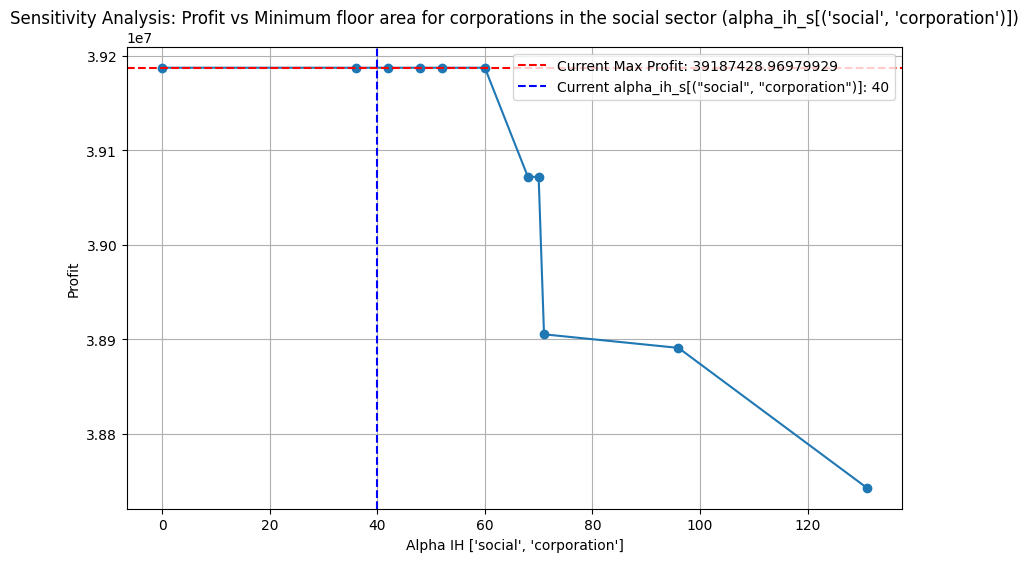

In [ ]:
alpha_ih_s = {
    ('social', 'corporation'): 40,
    ('middle', 'corporation'): 50,
    ('free', 'investor'): 60,
    ('social', 'investor'): 0,
    ('middle', 'investor'): 0,
    ('free', 'corporation'): 0,
    ('social', 'private'): 0,
    ('middle', 'private'): 0,
    ('free', 'private'): 0
}

# Parameters for the sensitivity analysis
current_alpha_ih = alpha_ih_s[('social', 'corporation')]
current_profit = 39187428.96979929  # Current max profit
alpha_ih_range = [0, 36, 42, 48, 52, 60, 68, 70, 71, 96,131]  # Range of values for ('social', 'corporation')

# Lists to store the results
alpha_values = []
profits = []

# ---- Calculations ----
for alpha_value in alpha_ih_range:
    print(f"Solving for alpha_ih_s[('social', 'corporation')] = {alpha_value}")

    # Update alpha_ih_s[('social', 'corporation')] to the new value
    alpha_ih_s[('social', 'corporation')] = alpha_value

    # Solve the model with updated alpha_ih
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma, alpha_ih_s)
    solve_model(ms, solv='cbc')

    # Store the alpha value and the corresponding profit
    alpha_values.append(alpha_value)
    profits.append(ms.obj())

# ---- Plotting ----
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, profits, marker='o')

# Mark the current max profit and current alpha_ih value
plt.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
plt.axvline(x=current_alpha_ih, color='b', linestyle='--', label=f'Current alpha_ih_s[("social", "corporation")]: {current_alpha_ih}')

plt.xlabel("Alpha IH ['social', 'corporation']")
plt.ylabel("Profit")
plt.title("Sensitivity Analysis: Profit vs Minimum floor area for corporations in the social sector (alpha_ih_s[('social', 'corporation')])")
plt.legend()
plt.grid(True)
plt.show()


## Sector % constraints

Solving for sector_constraints['social'] = 0
Maximum Profit: 52247498.8191072

Solving for sector_constraints['social'] = 0.1
Maximum Profit: 52247498.8191072

Solving for sector_constraints['social'] = 0.2
Maximum Profit: 52247498.8191072

Solving for sector_constraints['social'] = 0.25
Maximum Profit: 52080657.808449864

Solving for sector_constraints['social'] = 0.29
Maximum Profit: 51555050.86876165

Solving for sector_constraints['social'] = 0.32
Maximum Profit: 49914303.367647916

Solving for sector_constraints['social'] = 0.38
Maximum Profit: 41892754.73386284

Solving for sector_constraints['social'] = 0.4
Maximum Profit: 39187428.96979929

Solving for sector_constraints['social'] = 0.42
Maximum Profit: 35587644.77702729

Solving for sector_constraints['social'] = 0.45
Maximum Profit: 30284754.685634024

Solving for sector_constraints['social'] = 0.5
Maximum Profit: 21211153.836317383

Solving for sector_constraints['social'] = 0.55
Maximum Profit: 10448620.55239814

Solving fo

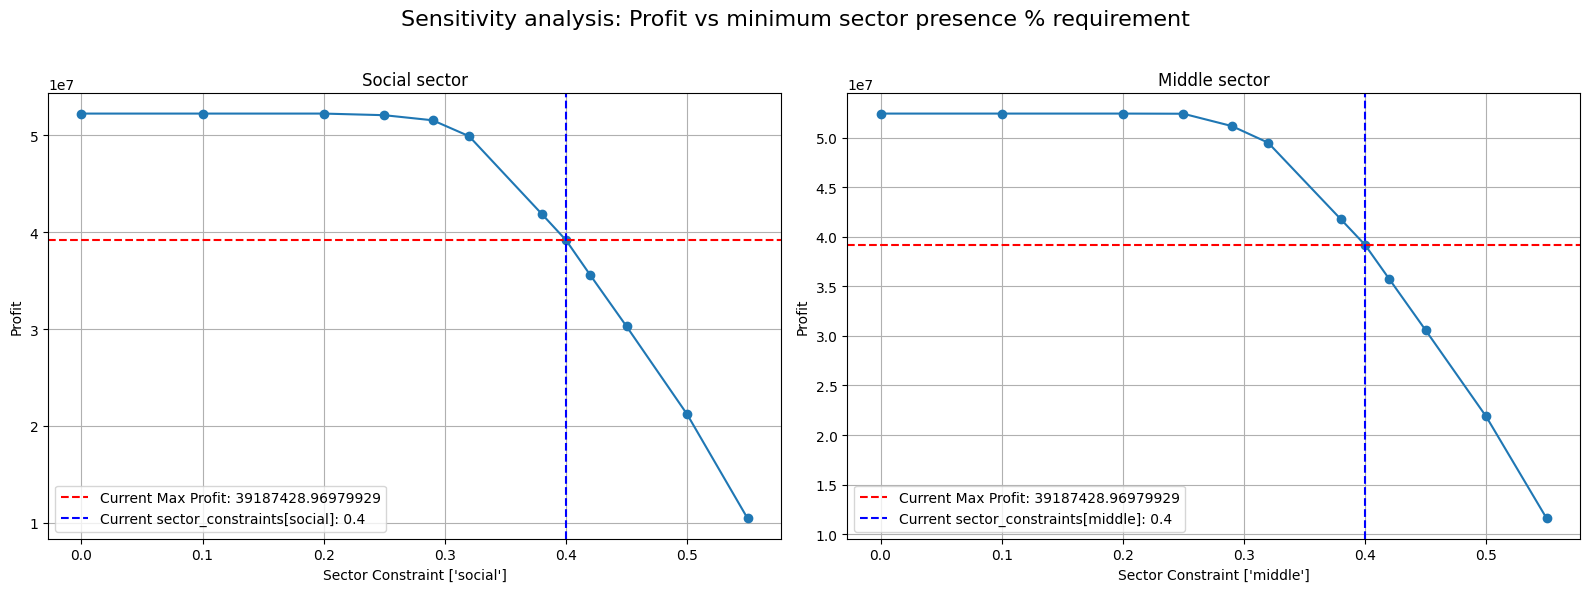

In [ ]:
import matplotlib.pyplot as plt

# Data for the first chart (social sector constraint)
sector_constraints_s = {
    'social': 0.4,
    'middle': 0.4,
    'free': 0.0
}

current_sector_constraint_social = sector_constraints_s['social']
current_profit = 39187428.96979929  # Current max profit
social_constraint_range = [0,0.1,0.2,0.25,0.29, 0.32,0.38, 0.4, 0.42,0.45, 0.5, 0.55]  # Range of values for the social sector constraint
social_values = []
profits_social = []

# ---- Calculations for the first chart ----
for social_value in social_constraint_range:
    print(f"Solving for sector_constraints['social'] = {social_value}")

    # Update sector_constraints['social'] to the new value
    sector_constraints_s['social'] = social_value

    # Solve the model with updated sector constraints
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints_s, owner_constraints, gamma, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the social constraint value and the corresponding profit
    social_values.append(social_value)
    profits_social.append(ms.obj())

# Data for the second chart (middle sector constraint)
sector_constraints_s = {
    'social': 0.4,
    'middle': 0.4,
    'free': 0.0
}

current_sector_constraint_middle = sector_constraints_s['middle']
middle_constraint_range = [0, 0.1, 0.2, 0.25, 0.29,0.32, 0.38, 0.4, 0.42, 0.45, 0.5, 0.55]  # Range of values for the middle sector constraint
middle_values = []
profits_middle = []

# ---- Calculations for the second chart ----
for middle_value in middle_constraint_range:
    print(f"Solving for sector_constraints['middle'] = {middle_value}")

    # Update sector_constraints['middle'] to the new value
    sector_constraints_s['middle'] = middle_value

    # Solve the model with updated sector constraints
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints_s, owner_constraints, gamma, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the middle constraint value and the corresponding profit
    middle_values.append(middle_value)
    profits_middle.append(ms.obj())

# ---- Plotting both charts side by side with a common title ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First plot (social sector)
ax1.plot(social_values, profits_social, marker='o')
ax1.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax1.axvline(x=current_sector_constraint_social, color='b', linestyle='--', label=f'Current sector_constraints[social]: {current_sector_constraint_social}')
ax1.set_xlabel("Sector Constraint ['social']")
ax1.set_ylabel("Profit")
ax1.set_title("Social sector")
ax1.legend()
ax1.grid(True)

# Second plot (middle sector)
ax2.plot(middle_values, profits_middle, marker='o')
ax2.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax2.axvline(x=current_sector_constraint_middle, color='b', linestyle='--', label=f'Current sector_constraints[middle]: {current_sector_constraint_middle}')
ax2.set_xlabel("Sector Constraint ['middle']")
ax2.set_ylabel("Profit")
ax2.set_title("Middle sector")
ax2.legend()
ax2.grid(True)

# Common title for the entire figure
fig.suptitle("Sensitivity analysis: Profit vs minimum sector presence % requirement", fontsize=16)

# Display the combined plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the common title
plt.show()


## Owner % constraint

Solving for owner_constraints['investor'] = 0.4
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.5
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.55
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.6
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.65
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.7
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.75
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.8
Maximum Profit: 38697609.27650259

Solving for owner_constraints['investor'] = 0.85
Maximum Profit: 30602601.363432966

Solving for owner_constraints['investor'] = 0.9
Maximum Profit: 22479105.042632587



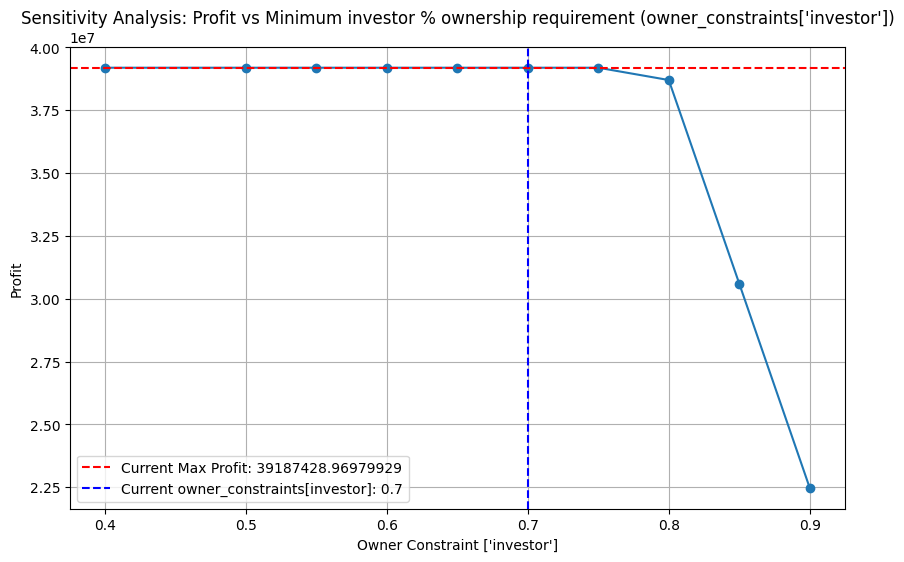

In [ ]:
owner_constraints_s = {
    'investor': 0.7,      # Investors must own at least 70% of the apartments
    'corporation': 0.0,   # No minimum for corporations
    'private': 0.0        # No minimum for private owners
}

# Parameters for the sensitivity analysis
current_owner_constraint = owner_constraints['investor']
current_profit = 39187428.96979929  # Current max profit
investor_constraint_range = [0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]  # Range of values for the investor constraint

# Lists to store the results
investor_values = []
profits = []

# ---- Calculations ----
for investor_value in investor_constraint_range:
    print(f"Solving for owner_constraints['investor'] = {investor_value}")

    # Update owner_constraints['investor'] to the new value
    owner_constraints_s['investor'] = investor_value

    # Solve the model with updated owner constraints
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints_s, gamma, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the investor constraint value and the corresponding profit
    investor_values.append(investor_value)
    profits.append(ms.obj())

# ---- Plotting ----
plt.figure(figsize=(10, 6))
plt.plot(investor_values, profits, marker='o')

# Mark the current max profit and current investor constraint value
plt.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
plt.axvline(x=current_owner_constraint, color='b', linestyle='--', label=f'Current owner_constraints[investor]: {current_owner_constraint}')

plt.xlabel("Owner Constraint ['investor']")
plt.ylabel("Profit")
plt.title("Sensitivity Analysis: Profit vs Minimum investor % ownership requirement (owner_constraints['investor'])")
plt.legend()
plt.grid(True)
plt.show()


Solving for owner_constraints['investor'] = 0.4
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.5
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.55
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.6
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.65
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.7
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.75
Maximum Profit: 39187428.96979929

Solving for owner_constraints['investor'] = 0.8
Maximum Profit: 38697609.27650259

Solving for owner_constraints['investor'] = 0.85
Maximum Profit: 30602601.363432966

Solving for owner_constraints['investor'] = 0.9
Maximum Profit: 22479105.042632587

Solving for owner_constraints['corporation'] = 0
Maximum Profit: 39187428.96979929

Solving for owner_constraints['corporation'] = 0.05
Maximum Profit: 38951474.058

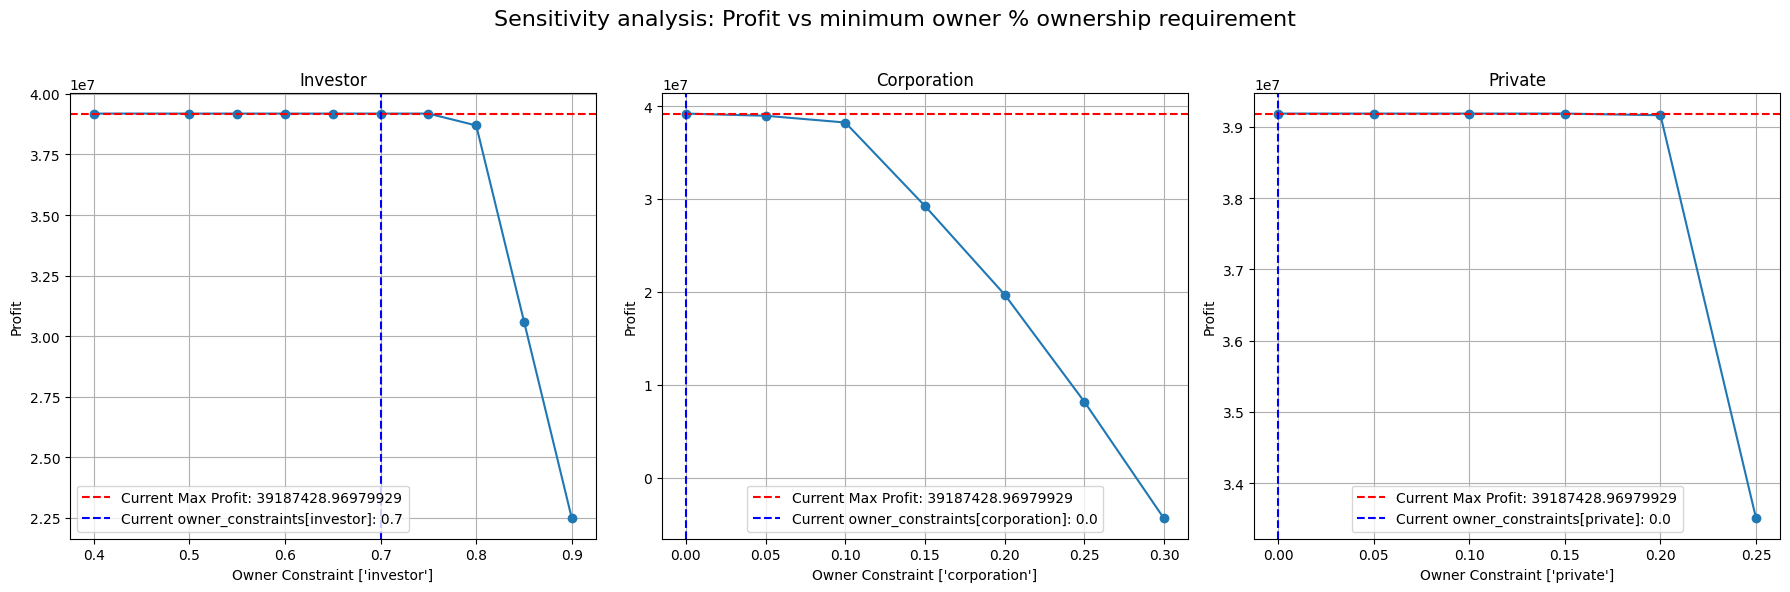

In [ ]:
import matplotlib.pyplot as plt

# Data for the first chart (owner_constraints['investor'])
owner_constraints_s = {
    'investor': 0.7,
    'corporation': 0.0,
    'private': 0.0
}

# Parameters for the sensitivity analysis
current_owner_constraint_investor = owner_constraints['investor']
current_profit = 39187428.96979929  # Current max profit
investor_constraint_range = [0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]  # Range of values for the investor constraint
investor_values = []
profits_investor = []

# ---- Calculations for the first chart (investor) ----
for investor_value in investor_constraint_range:
    print(f"Solving for owner_constraints['investor'] = {investor_value}")

    # Update owner_constraints['investor'] to the new value
    owner_constraints_s['investor'] = investor_value

    # Solve the model with updated owner constraints
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints_s, gamma, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the investor constraint value and the corresponding profit
    investor_values.append(investor_value)
    profits_investor.append(ms.obj())

# Data for the second chart (owner_constraints['corporation'])
corporation_constraint_range = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
corporation_values = []
profits_corporation = []
owner_constraints_s = {
    'investor': 0.7,
    'corporation': 0.0,
    'private': 0.0
}
# ---- Calculations for the second chart (corporation) ----
for corporation_value in corporation_constraint_range:
    print(f"Solving for owner_constraints['corporation'] = {corporation_value}")

    # Update owner_constraints['corporation'] to the new value
    owner_constraints_s['corporation'] = corporation_value

    # Solve the model with updated owner constraints
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints_s, gamma, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the corporation constraint value and the corresponding profit
    corporation_values.append(corporation_value)
    profits_corporation.append(ms.obj())

# Data for the third chart (owner_constraints['private'])
private_constraint_range = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
private_values = []
profits_private = []
owner_constraints_s = {
    'investor': 0.7,
    'corporation': 0.0,
    'private': 0.0
}
# ---- Calculations for the third chart (private) ----
for private_value in private_constraint_range:
    print(f"Solving for owner_constraints['private'] = {private_value}")

    # Update owner_constraints['private'] to the new value
    owner_constraints_s['private'] = private_value

    # Solve the model with updated owner constraints
    ms = apartment_optimization(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints_s, gamma, alpha_ih)
    solve_model(ms, solv='cbc')

    # Store the private constraint value and the corresponding profit
    private_values.append(private_value)
    profits_private.append(ms.obj())

# ---- Plotting the three charts side by side with a common title ----
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# First plot (investor)
ax1.plot(investor_values, profits_investor, marker='o')
ax1.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax1.axvline(x=current_owner_constraint_investor, color='b', linestyle='--', label=f'Current owner_constraints[investor]: {current_owner_constraint_investor}')
ax1.set_xlabel("Owner Constraint ['investor']")
ax1.set_ylabel("Profit")
ax1.set_title("Investor")
ax1.legend()
ax1.grid(True)

# Second plot (corporation)
ax2.plot(corporation_values, profits_corporation, marker='o')
ax2.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax2.axvline(x=0.0, color='b', linestyle='--', label=f'Current owner_constraints[corporation]: 0.0')
ax2.set_xlabel("Owner Constraint ['corporation']")
ax2.set_ylabel("Profit")
ax2.set_title("Corporation")
ax2.legend()
ax2.grid(True)

# Third plot (private)
ax3.plot(private_values, profits_private, marker='o')
ax3.axhline(y=current_profit, color='r', linestyle='--', label=f'Current Max Profit: {current_profit}')
ax3.axvline(x=0.0, color='b', linestyle='--', label=f'Current owner_constraints[private]: 0.0')
ax3.set_xlabel("Owner Constraint ['private']")
ax3.set_ylabel("Profit")
ax3.set_title("Private")
ax3.legend()
ax3.grid(True)

# Common title for the entire figure
fig.suptitle("Sensitivity analysis: Profit vs minimum owner % ownership requirement", fontsize=16)

# Display the combined plots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the common title
plt.show()


## If corporation could buy free sector apartments

In [ ]:
def apartment_optimization_alt2(number_of_apartments_df, profit_df, K, sector_constraints, owner_constraints, gamma, alpha_ih):
    # Create the model
    m = pyo.ConcreteModel('ApartmentOptimization')

    # Define Sets
    m.sectors = pyo.Set(initialize=profit_df['sector'].unique())  # Sectors (i)
    m.areas = pyo.Set(initialize=number_of_apartments_df['area'].unique())  # Areas (j)
    m.owners = pyo.Set(initialize=profit_df['owner'].unique())  # Owners (h)
    m.configurations = pyo.Set(initialize=number_of_apartments_df['configuration'].unique())  # Configurations (v)

    # Define Parameters from Excel data
    m.R_jv = pyo.Param(m.areas, m.configurations, initialize=number_of_apartments_df.set_index(['area', 'configuration']).to_dict()['no_of_apartments'])  # Number of apartments with area j and configuration v
    m.O_ijh = pyo.Param(m.sectors, m.areas, m.owners, initialize=profit_df.set_index(['sector', 'area', 'owner']).to_dict()['profit'], default=0)  # Profit per apartment

    # Define Decision Variables
    m.Xv = pyo.Var(m.configurations, bounds=(0, K), within=pyo.NonNegativeIntegers)  # Number of floors with configuration v
    m.Yijh = pyo.Var(m.sectors, m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of apartments
    m.Wvh = pyo.Var(m.configurations, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Number of floors by owner h
    m.Zjh = pyo.Var(m.areas, m.owners, bounds=(0, None), within=pyo.NonNegativeIntegers)  # Total apartments by area and owner

    # Objective function: Maximize total profit
    @m.Objective(sense=pyo.maximize)
    def obj(m):
        return pyo.quicksum(m.O_ijh[i, j, h] * m.Yijh[i, j, h] for i in m.sectors for j in m.areas for h in m.owners)

    # Constraints

    # 1. Total number of floors equals K
    @m.Constraint()
    def total_floors(m):
        return pyo.quicksum(m.Xv[v] for v in m.configurations) == K

    # 2. Total number of apartments consistency
    @m.Constraint(m.areas)
    def total_apartments(m, j):
        return pyo.quicksum(m.R_jv[j, v] * m.Xv[v] for v in m.configurations) == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for h in m.owners)

    # 3. Owner floor configuration
    @m.Constraint(m.configurations)
    def owner_floors(m, v):
        return pyo.quicksum(m.Wvh[v, h] for h in m.owners) == m.Xv[v]

    # 4. No multiple owners on the same floor
    @m.Constraint(m.areas, m.owners)
    def no_multiple_owners(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Wvh[v, h] * m.R_jv[j, v] for v in m.configurations)

    # 5. Ensure consistency of apartments assigned by owner and area
    @m.Constraint(m.areas, m.owners)
    def apartments_owner_area(m, j, h):
        return m.Zjh[j, h] == pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors)

    # 6. Sector constraints (minimum percentage in total program)
    @m.Constraint(m.sectors)
    def sector_minimum(m, i):
        return pyo.quicksum(m.Yijh[i, j, h] for j in m.areas for h in m.owners) >= sector_constraints[i] * pyo.quicksum(m.Yijh[l, j, h] for l in m.sectors for j in m.areas for h in m.owners)

    # 7. Minimal average floor area of apartments in a sector
    @m.Constraint(m.sectors)
    def minumum_average_floor_area(m, i):
        return pyo.quicksum(j * m.Yijh[i,j,h] for j in m.areas for h in m.owners) >= gamma[i] * pyo.quicksum(m.Yijh[i,j,h] for j in m.areas for h in m.owners)

    # 8. Minimal floor area for sector and owner
    @m.Constraint(m.sectors, m.areas, m.owners)
    def minimum_floor_area_constraint(m, i, j, h):
      if j < alpha_ih[i, h]:
          return m.Yijh[i, j, h] == 0
      else:
          return pyo.Constraint.Skip

    # # 9. No free sector apartments for housing corporation
    # @m.Constraint(m.areas)
    # def no_free_sector_apartments(m, j):
    #     return m.Yijh['free', j, 'corporation'] == 0

    # 10. Owner constraints (e.g., percentage for investors)
    @m.Constraint(m.owners)
    def owner_percentage(m, h):
        return pyo.quicksum(m.Yijh[i, j, h] for i in m.sectors for j in m.areas) >= owner_constraints[h] * pyo.quicksum(m.Yijh[i, j, p] for i in m.sectors for j in m.areas for p in m.owners)



    return m

# Solve the model
K = 56
m4 = apartment_optimization_alt2(df_number_of_apartments, df_profit_height_168, K, sector_constraints, owner_constraints, gamma, alpha_ih)
solve_model(m3, solv='cbc')

Maximum Profit: 39187428.96979929

